Course:
<br>https://www.udemy.com/course/data-fusion-with-linear-kalman-filter/

### Import libraries 

In [250]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

np.set_printoptions(suppress=True)

### Kalman filter description

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Kalman-filter_en.svg/1280px-Kalman-filter_en.svg.png"  width = 600 height=300 />
<i>https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Kalman-filter_en.svg/1280px-Kalman-filter_en.svg.png</i>
<h4>Initial step</h4>
Firstly we have initial step that is either known or unknown. This will effect our uncertainty matrix. 
<h4>Prediction step</h4>
We calculate our prediction step, that is nothing less, than only calculation of our best estimate given the previous or initial data. 
<h4>Measurement</h4>
After that we obtain measurement. 
<h4>Innovation</h4>
When we obtain measurement, we are able to compare our best estimate with measurement and make correction using recursive least square error

### Problem statement

<br>
We have randomly generated position of x and y in descrete measurement and we try to calculate velocity of movement, its next position and acceleration. As the only measurement we are receiving is position it will effect our calculation matrix.
<br>
Lets start with velocity, that we can describe as:
<div style="width: 150px; height: 60px; overflow: hidden;">
    <div style="background-image: url('https://www.inchcalculator.com/wp-content/uploads/2023/08/velocity-formula-acceleration.png'); background-size: cover; background-position: center 50%; height: 100%;">
    </div>
</div>
<i>https://www.inchcalculator.com/wp-content/uploads/2023/08/velocity-formula-acceleration.png</i>
<br>
Then we have position:
<div style="width: 400px; height: 150px; overflow: hidden;">
    <div style="background-image: url('https://www.physicsthisweek.com/wp-content/uploads/2021/10/Kinematics-Position-Equation-Variables-200.png'); background-size: cover; background-position: center 50%; height: 100%;">
    </div>
</div>
<i>https://www.physicsthisweek.com/wp-content/uploads/2021/10/Kinematics-Position-Equation-Variables-200.png</i>
<br>
Now we put both quations into matrix form:
<img src="Images/Dumble_KF_rovnice.png"  width = 300 height=300 />
<i>Generated by ChatGPT3.5</i>
<br>
Now we put it into one big formula and we are good for Kalman filter.

Firstly we define object of vehicle, where we will store all data

In [405]:
class VehicleModel2D():

    def __init__(self):
        self.x_pos = 0
        self.y_pos = 0
        self.vel = 0
        self.yaw = 0

    def initialise(self, vehicle_params):
        self.x_pos = vehicle_params['initial_x_position']
        self.y_pos = vehicle_params['initial_y_position']
        self.yaw = vehicle_params['initial_heading']
        self.vel = vehicle_params['initial_speed']

    def update_vehicle(self, time_step, accel, yaw_rate):
        self.vel = self.vel + accel * time_step
        self.yaw = self.yaw + yaw_rate * time_step
        self.x_pos = self.x_pos + self.vel * np.cos(self.yaw) * time_step
        self.y_pos = self.y_pos + self.vel * np.sin(self.yaw) * time_step
        return

    def get_position(self):
        return [self.x_pos, self.y_pos]

    def get_velocity(self):
        x_vel = self.vel * np.cos(self.yaw)
        y_vel = self.vel * np.sin(self.yaw)
        return [x_vel, y_vel]

    def get_speed(self):
        return self.vel

    def get_heading(self):
        return self.yaw

Then we run simulation of measurement and display real value of drivin

In [406]:
def run_simulation_(motion_type:str,
                   start_at_origin:bool,
                   initial_speed:int,
                   start_at_random_speed:bool,
                   start_at_random_heading:bool,
                   dt:float=0.01,
                   end_time:int=120,
                   measurement_noise_std:float=1):
    # Create the Simulation Objects
    vehicle_model = VehicleModel2D()
    # number of steps
    num_steps = np.ceil(end_time/dt).astype(int)
    
    # Define init position
    initial_x_position = 0
    initial_y_position = 0
    if start_at_origin == False:
        initial_x_position += 1000*(np.random.rand()-0.5)
        initial_y_position += 1000*(np.random.rand()-0.5)
        
    # Define init speed
    if start_at_random_speed == True:
        initial_speed += initial_speed + np.random.rand() * 20
        
    # Define init heading
    initial_heading = 45
    if start_at_random_heading == True:
        initial_heading += 180*(np.random.rand()-0.5)
        
    # put init params into dict
    vehicle_params = {'initial_x_position': initial_x_position,
                      'initial_y_position': initial_x_position,
                      'initial_heading': np.deg2rad(initial_heading),
                      'initial_speed': initial_speed}
    # initialize vehicle
    vehicle_model.initialise(vehicle_params)
    
    # create time list
    time_history = np.linspace(0.0, dt*num_steps, num_steps+1)
    
    # create lists of stored values with init values
    vehicle_position_history = [vehicle_model.get_position()]
    vehicle_velocity_history = [vehicle_model.get_velocity()]
    x_meas = vehicle_model.get_position()[0] + np.random.randn()*measurement_noise_std
    y_meas = vehicle_model.get_position()[1] + np.random.randn()*measurement_noise_std
    measurement = [x_meas,y_meas]
    measurement_history = [measurement]
    
    # define again random param
    rand_param = np.random.randn()*0.1
    acceleration_history = [rand_param]
    
    # Run the Simulation
    for k in range(1, num_steps+1):
        # update vehicle with current step and random acceleration, which is for us noise as we dont have measurement
        acceleration_history.append(rand_param)
        # Update the Vehicle Model
        if motion_type == 'random':
            vehicle_model.update_vehicle(dt, np.random.randn()*2 , np.random.randn()*2)
        elif motion_type == 'circle':
            vehicle_model.update_vehicle(dt, 0 , np.deg2rad(360/120))
        elif motion_type == 'linear':
            vehicle_model.update_vehicle(dt,rand_param,0)
        else:
            vehicle_model.update_vehicle(dt, 0, 0)
        # get position
        vehicle_position = vehicle_model.get_position()
        vehicle_velocity = vehicle_model.get_velocity()
        # measurement
        x_meas = vehicle_position[0] + np.random.randn()*measurement_noise_std
        y_meas = vehicle_position[1] + np.random.randn()*measurement_noise_std
        measurement = [x_meas,y_meas]
        # Save Data
        vehicle_position_history.append(vehicle_model.get_position())
        vehicle_velocity_history.append(vehicle_model.get_velocity())
        measurement_history.append(measurement)
        
    return (measurement_history,
            vehicle_position_history,
            vehicle_velocity_history)

In [407]:
timestep = 0.01

In [408]:
measurement_history, vehicle_position_history,  vehicle_velocity_history = run_simulation_(    
                   motion_type="linear",
                   start_at_origin=True,
                   initial_speed = 10, 
                   start_at_random_speed=False,
                   start_at_random_heading=False,
                   dt=timestep,
                   end_time=120,
                   measurement_noise_std = 1)

<IPython.core.display.Javascript object>


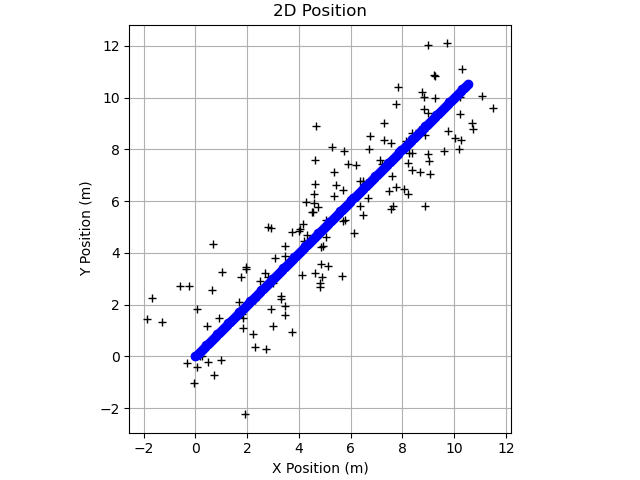

In [409]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True)
fig_ax2 = fig_of_plot.add_subplot(111,title='2D Position', aspect='equal')#, autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax2.set_xlabel('X Position (m)')
fig_ax2.set_ylabel('Y Position (m)')
fig_ax2.grid(True)

meas_plot, = fig_ax2.plot([],[],'+k')
vehicle_plot, = fig_ax2.plot([], [], 'bo-', lw=1)

def update_plot(i):
    meas_plot.set_data(np.array(measurement_history)[:i].T)
    vehicle_plot.set_data(np.array(vehicle_position_history)[:i].T)
    fig_ax2.relim()
    fig_ax2.autoscale_view()
    return vehicle_plot,meas_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=150, interval=0.01)


plt.show()

<h4>Lets implement prediction step of Kalman filter</h4>
<ul>
  <li>We see two equations for "v"=velocity and "p"=position</li>
  <li>We put these equations into matrix form and change t to discrete value of delta t</li>
  <li>Finally we add direction of velocity and position in 2D, so "x" and "y" in our case</li>
  <li>As we dont have measurements of acceleration we move acceleration from "G", which stands for inputs into "L", which stands for noise</li>
</ul>
<img src="images/Kalman_filter_prediction_initial_formulas.jpg"  width = 800 height=300 />

<ul>
  <li>We move one and put everything into estimation formula of "x", which consist of transformation matrix of state "x", state "F", transformation matrix of noise "w", noise "L", transformation matrix of input "u" and input "G"</li>
  <li>From out estimation formula we will derive covariance matrix, that consist from previous covariance matrices and state with noise as those are only two values coming into our system.</li>
  <li>We can assume, that noise is additive, therefore Lk is equal to identity matrix and we can simplify our formula</li>
</ul>
<img src="images/Kalman_filter_prediction_p_definition.jpg"  width = 800 height=300 />

Are final formulas are: 
<img src="Images/Kalman_filter_prediction_final_formulas.jpg"  width = 800 height=300 />
As we can see from formula, we have no input, therefore this part is 0 and we can remove it and our formulas are simpler. 
<br>
These formulas we will use for our implementation

In [410]:
# Definition of Kalman filter
class KalmanFilterBase:
    def __init__(self):
        # variables we would like to track
        self.state = None
        self.covariance = None
        self.innovation = None
        self.innovation_covariance = None

    def get_current_state(self):
        if self.state is not None:
            return self.state.tolist()
        return None

    def get_current_covariance(self):
        if self.covariance is not None:
            return self.covariance.tolist()
        return None

    def get_last_innovation(self):
        if self.innovation is not None:
            return self.innovation.tolist()
        return None

    def get_last_innovation_covariance(self):
        if self.innovation_covariance is not None:
            return self.innovation_covariance.tolist()
        return None

In [411]:
"""Kalman Filter Model implementation of initialization with default parameter, 
which equals to parameters of our created measurement 
"""
class KalmanFilterModel(KalmanFilterBase):
    
    def initialise(self, time_step, accel_std):
        dt = time_step
        
        # Set Initial State and Covariance
        self.state = np.array([0, 0, 7.07, 7.07])
        self.covariance = np.diag(np.array([0, 0, 0, 0]))
        
        # Set Model F and H Matrices
        self.F = np.array([[1,0,dt,0],
                           [0,1,0,dt],
                           [0,0,1,0],
                           [0,0,0,1]])

        self.H = np.array([[1,0,0,0],[0,1,0,0]])

        # Set Q matrix
        self.Q = np.diag(np.array([(0.5*dt*dt),(0.5*dt*dt),dt,dt]) * (accel_std*accel_std))
    
        return
    
    def prediction_step(self):
        # Make Sure Filter is Initialised
        if self.state is not None:
            x = self.state
            P = self.covariance

            # Calculate Kalman Filter Prediction
            x_predict = np.matmul(self.F, x) 
            P_predict = np.matmul(self.F, np.matmul(P, np.transpose(self.F))) + self.Q

            # Save Predicted State
            self.state = x_predict
            self.covariance = P_predict
        return

    def update_step(self, measurement):
        pass 

In [412]:
timestep = 0.01

In [413]:
kf_options = {'accel_std':0.1, # Q Matrix Param
              'time_step':timestep
             }


In [414]:
measurement_history, vehicle_position_history,  vehicle_velocity_history = run_simulation_(    
                   motion_type="straight",
                   start_at_origin=True,
                   initial_speed = 10, 
                   start_at_random_speed=False,
                   start_at_random_heading=False,
                   dt=timestep,
                   end_time=120,
                   measurement_noise_std = 1)

In [415]:
kalman_filter = KalmanFilterModel()
kalman_filter.initialise(**kf_options)

states = []
covariances = []
estimation_errors = []
for step_id in range(len(measurement_history)):
    # KF Prediction
    kalman_filter.prediction_step()
    states.append(kalman_filter.get_current_state())
    covariances.append(kalman_filter.get_current_covariance())
    estimation_errors.append(np.array(kalman_filter.get_current_state()) 
                             - np.array((vehicle_position_history[step_id] + vehicle_velocity_history[step_id])))
states = np.array(states)
covariances = np.array(covariances)
estimation_errors = np.array(estimation_errors)
measurement_history = np.array(measurement_history)
vehicle_velocity_history = np.array(vehicle_velocity_history)

From the following graph we are able to see, that if we guess initial state somehow close to real values, our model will look as its working, but its not able to learn.

<IPython.core.display.Javascript object>


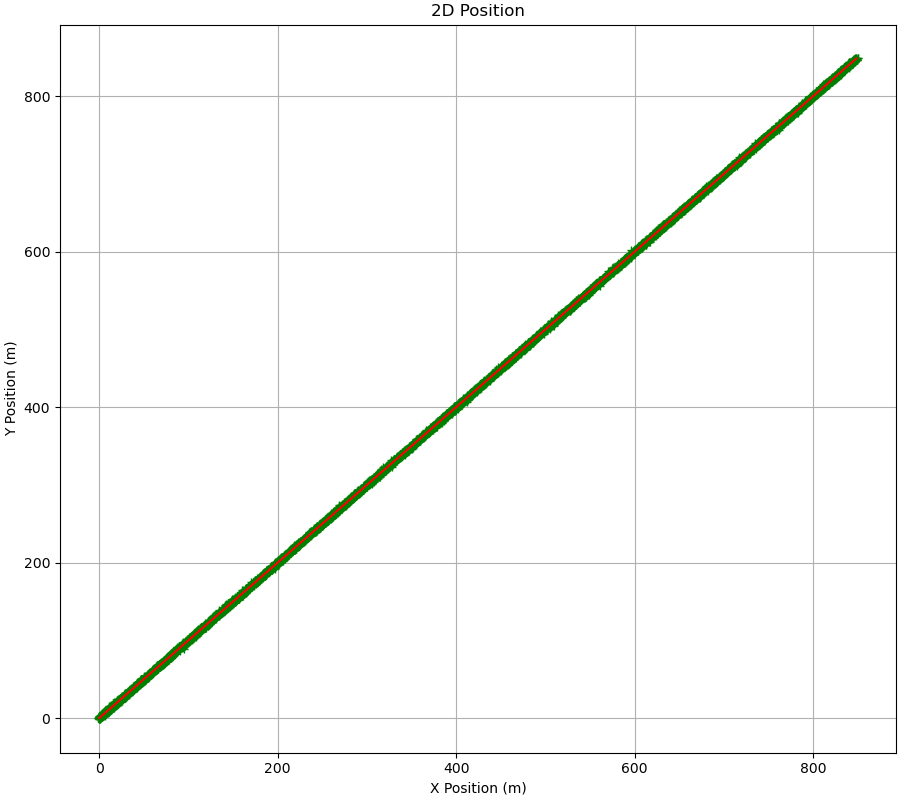

In [418]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True, figsize = (9,8))
fig_ax2 = fig_of_plot.add_subplot(111,title='2D Position')#, aspect='equal', autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax2.set_xlabel('X Position (m)')
fig_ax2.set_ylabel('Y Position (m)')
fig_ax2.grid(True)

meas_plot, = fig_ax2.plot([],[],'+g')
vehicle_plot, = fig_ax2.plot([], [], '-r')


def update_plot(i):
    meas_plot.set_data(np.array(measurement_history)[:i*100].T)
    vehicle_plot.set_data(np.array(states)[:i*100,0:2].T)
    fig_ax2.relim()
    fig_ax2.autoscale_view()
    return vehicle_plot,meas_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=math.ceil(len(estimation_errors)/100), interval=0.0001)


plt.show()

Following graph is showing, that we are able with our guess somehow follow reality.

<IPython.core.display.Javascript object>


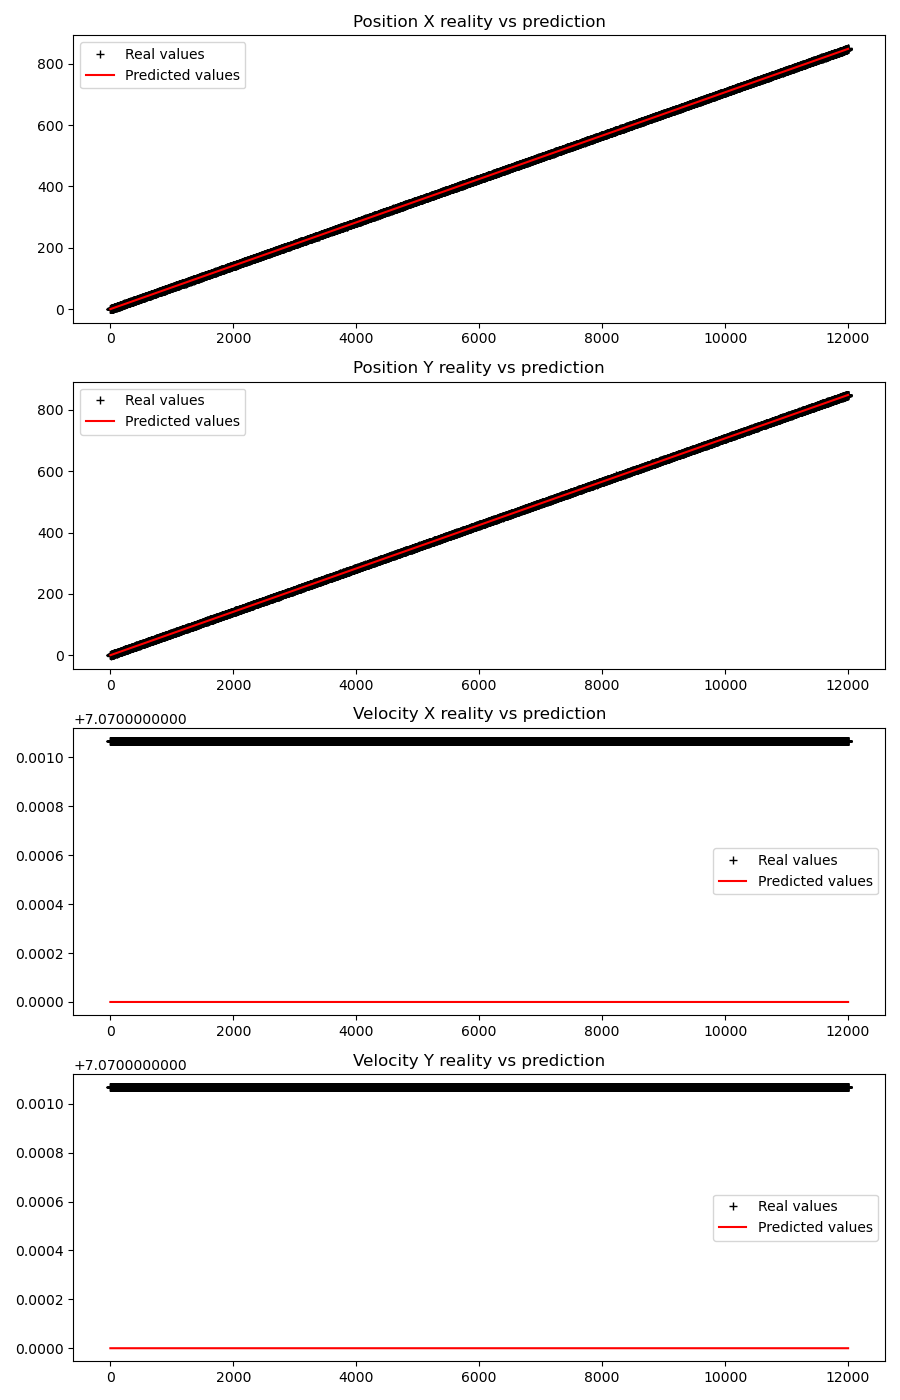

In [419]:
fig, ax = plt.subplots(4,1,figsize = (9,14))

ax[0].plot(measurement_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Position X reality vs prediction")

ax[1].plot(measurement_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Position Y reality vs prediction")

ax[2].plot(vehicle_velocity_history[:,0], "+k", label = "Real values")
ax[2].plot(states[:,2], "-r", label = "Predicted values")
ax[2].legend()
ax[2].set_title("Velocity X reality vs prediction")

ax[3].plot(vehicle_velocity_history[:,1], "+k", label = "Real values")
ax[3].plot(states[:,3], "-r", label = "Predicted values")
ax[3].legend()
ax[3].set_title("Velocity Y reality vs prediction")

plt.tight_layout()
plt.show()

We can also see as our model is not learning, that model covariance is exponentialy growing.

<IPython.core.display.Javascript object>


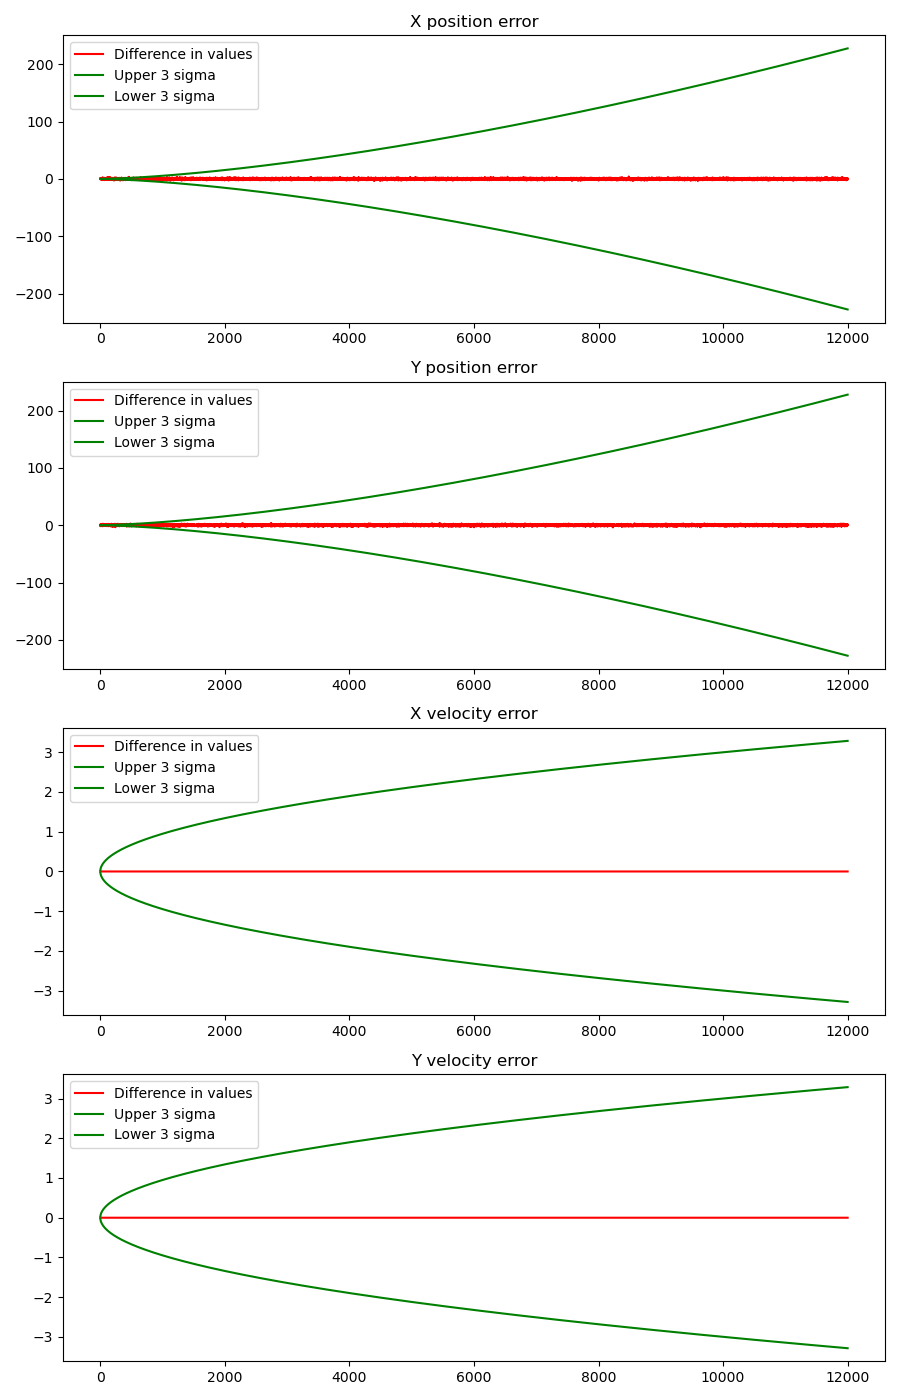

In [420]:
fig, ax = plt.subplots(4,1,figsize = (9,14))

ax[0].plot(states[:,0]-measurement_history[:,0], "-r", label = "Difference in values")
ax[0].plot(3*np.sqrt(covariances[:,0,0]), "-g", label = "Upper 3 sigma")
ax[0].plot(-3*np.sqrt(covariances[:,0,0]), "-g", label = "Lower 3 sigma")
ax[0].legend()
ax[0].set_title("X position error")

ax[1].plot(states[:,1]-measurement_history[:,1], "-r", label = "Difference in values")
ax[1].plot(3*np.sqrt(covariances[:,1,1]), "-g", label = "Upper 3 sigma")
ax[1].plot(-3*np.sqrt(covariances[:,1,1]), "-g", label = "Lower 3 sigma")
ax[1].legend()
ax[1].set_title("Y position error")


ax[2].plot(states[:,2]-vehicle_velocity_history[:,0], "-r", label = "Difference in values")
ax[2].plot(3*np.sqrt(covariances[:,2,2]), "-g", label = "Upper 3 sigma")
ax[2].plot(-3*np.sqrt(covariances[:,2,2]), "-g", label = "Lower 3 sigma")
ax[2].legend()
ax[2].set_title("X velocity error")

ax[3].plot(states[:,3]-vehicle_velocity_history[:,1], "-r", label = "Difference in values")
ax[3].plot(3*np.sqrt(covariances[:,3,3]), "-g", label = "Upper 3 sigma")
ax[3].plot(-3*np.sqrt(covariances[:,3,3]), "-g", label = "Lower 3 sigma")
ax[3].legend()
ax[3].set_title("Y velocity error")

plt.tight_layout()
plt.show()

<h4>Lets implement update step of Kalman filter</h4>
<h5>Prediction step</h5>
<ul>
    <li>Firstly we have to move our model in time and get new state matrix. This meaans to multiply transition matrix "F" with last state matrix "x(k-1)".</li>
    <li>For this new state we calculate model covariance.</li>
</ul>
<h5>Update step</h5>
<ul>
  <li>Firstly lets start with "Sk", which is innovation estimate. This is nothing than comparing of model noise with measurement noise.</li>
  <li>From innovation estimate "Sk", we can calculate gain matrix "Kk", that is defining how much we should change our states in compare to measurement.</li>
  <li>Then we calculate our updated state</li>
  <li>Lastly we calculate model covariance matrix after update</li>
</ul>
<img src="images/Kalman_complete_.jpg"  width = 800 height=300 />

In [613]:
class KalmanFilterModelWithUpade(KalmanFilterModel):
    def initialise(self, time_step):       
        # Set initial state = x
        #self.state = np.array([0, 0, 0, 0])
        
        # Set initial covarinace = P
        #init_pos_std = 0
        #init_vel_std = 0
        #self.covariance = np.diag(np.array([init_pos_std*init_pos_std,
        #                                    init_pos_std*init_pos_std,
        #                                    init_vel_std*init_vel_std,
        #                                    init_vel_std*init_vel_std]))
        
        # Define timestep = dt
        dt = time_step
        
        # Set state transition matrix = F
        self.F = np.array([[1,0,dt,0],
                           [0,1,0,dt],
                           [0,0,1,0],
                           [0,0,0,1]])
        
        # Set measurement model = H
        self.H = np.array([[1,0,0,0],[0,1,0,0]])

        # Set Process model noise = Q
        accel_std = 0.1
        self.Q = np.diag(np.array([(0.5*dt*dt),(0.5*dt*dt),dt,dt]) * (accel_std*accel_std))

        # Set covariance of measurement = R
        meas_std = 1
        self.R = np.diag([meas_std*meas_std, meas_std*meas_std])
        
        return
    
    def update_step(self, measurement):
        # Make Sure Filter is Initialised
        if self.state is not None and self.covariance is not None:
            x = self.state
            P = self.covariance
            H = self.H
            R = self.R
            
            # As we have only measurement of position, use only first two columns
            z = np.array([measurement[0],measurement[1]])
            
            # Calculate z_hat, which is our estimation of state
            z_hat = np.matmul(H, x)
            
            # Calculate innovation, which is different between estimation and real measurement
            y = z-z_hat
                
            # Calculate innovation covariance, which is how much uncertainty is between measurement and estimation
            S = np.matmul(H, np.matmul(P, H.T)) + R
            
            # Calculate gain matrix for update 
            K = np.matmul(P, np.matmul(H.T, np.linalg.inv(S)))
            
            # Calculate model update 
            x_update = x + np.matmul(K,y)
            
            # Calculate covariance of the model 
            P_update = np.matmul(P, np.eye(4) - (np.matmul(K,H)))
            
            # Save Updated State
            self.real_values = z
            self.predicted_values = z_hat
            self.innovation = y
            self.innovation_covariance = S
            self.state = x_update
            self.covariance = P_update
            self.gain_matrix = K
        else:
            self.gain_matrix = np.zeros([4,2])
            self.innovation = np.array([0, 0])
            # Set Initial State and Covariance 
            init_vel_std = 1

            self.state = np.array([measurement[0],measurement[1],0,0])
            self.covariance = np.diag(np.array([self.R[0,0],self.R[1,1],init_vel_std*init_vel_std,init_vel_std*init_vel_std]))
        return 

In [614]:
dt = 0.01

In [615]:
measurement_history, vehicle_position_history,  vehicle_velocity_history = run_simulation_(    
                   motion_type="linear",
                   start_at_origin=False,
                   initial_speed = 15, 
                   start_at_random_speed=True,
                   start_at_random_heading=False,
                   dt=dt,
                   end_time=120,
                   measurement_noise_std = 1)

In [616]:
kalman_filter_with_update = KalmanFilterModelWithUpade()
kalman_filter_with_update.initialise(time_step = dt)

states = []
covariances = []
estimation_errors = []
innovation = []
gain_values = []

for step_id, measurement_histry_record in enumerate(measurement_history):
    # KF Prediction
    kalman_filter_with_update.prediction_step()
    kalman_filter_with_update.update_step(measurement_histry_record)
    states.append(kalman_filter_with_update.get_current_state())
    covariances.append(np.array(kalman_filter_with_update.get_current_covariance()))
    innovation.append(kalman_filter_with_update.innovation.reshape(1,-1))
    gain_values.append(kalman_filter_with_update.gain_matrix)
    estimation_errors.append(np.array(kalman_filter.get_current_state()) 
                             - np.array((vehicle_position_history[step_id] + vehicle_velocity_history[step_id])))
    
states = np.array(states)
covariances = np.array(covariances)
estimation_errors = np.array(estimation_errors)
measurement_history = np.array(measurement_history)
vehicle_velocity_history = np.array(vehicle_velocity_history)
innovation = np.array(np.squeeze(innovation))
gain_values = np.array(gain_values)

<IPython.core.display.Javascript object>


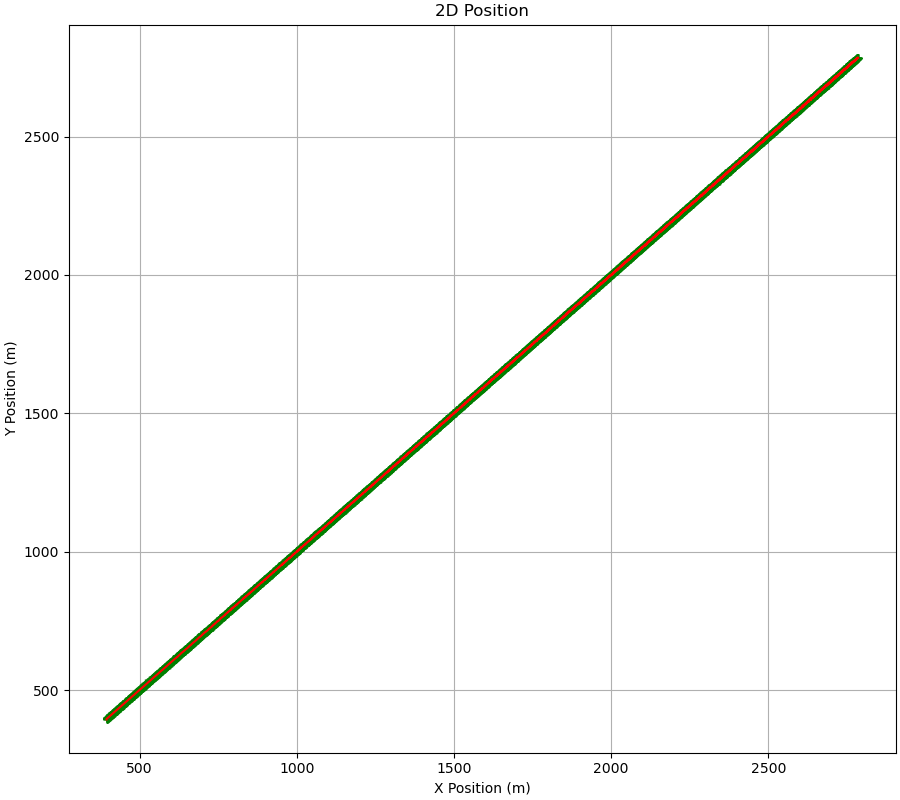

In [617]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True, figsize = (9,8))
fig_ax2 = fig_of_plot.add_subplot(111,title='2D Position')#, aspect='equal', autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax2.set_xlabel('X Position (m)')
fig_ax2.set_ylabel('Y Position (m)')
fig_ax2.grid(True)

meas_plot, = fig_ax2.plot([],[],'+g')
vehicle_plot, = fig_ax2.plot([], [], '-r')


def update_plot(i):
    meas_plot.set_data(np.array(measurement_history)[:i*100].T)
    vehicle_plot.set_data(np.array(states)[:i*100,0:2].T)
    fig_ax2.relim()
    fig_ax2.autoscale_view()
    return vehicle_plot,meas_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=math.ceil(len(estimation_errors)/100), interval=0.0001)


plt.show()

<IPython.core.display.Javascript object>


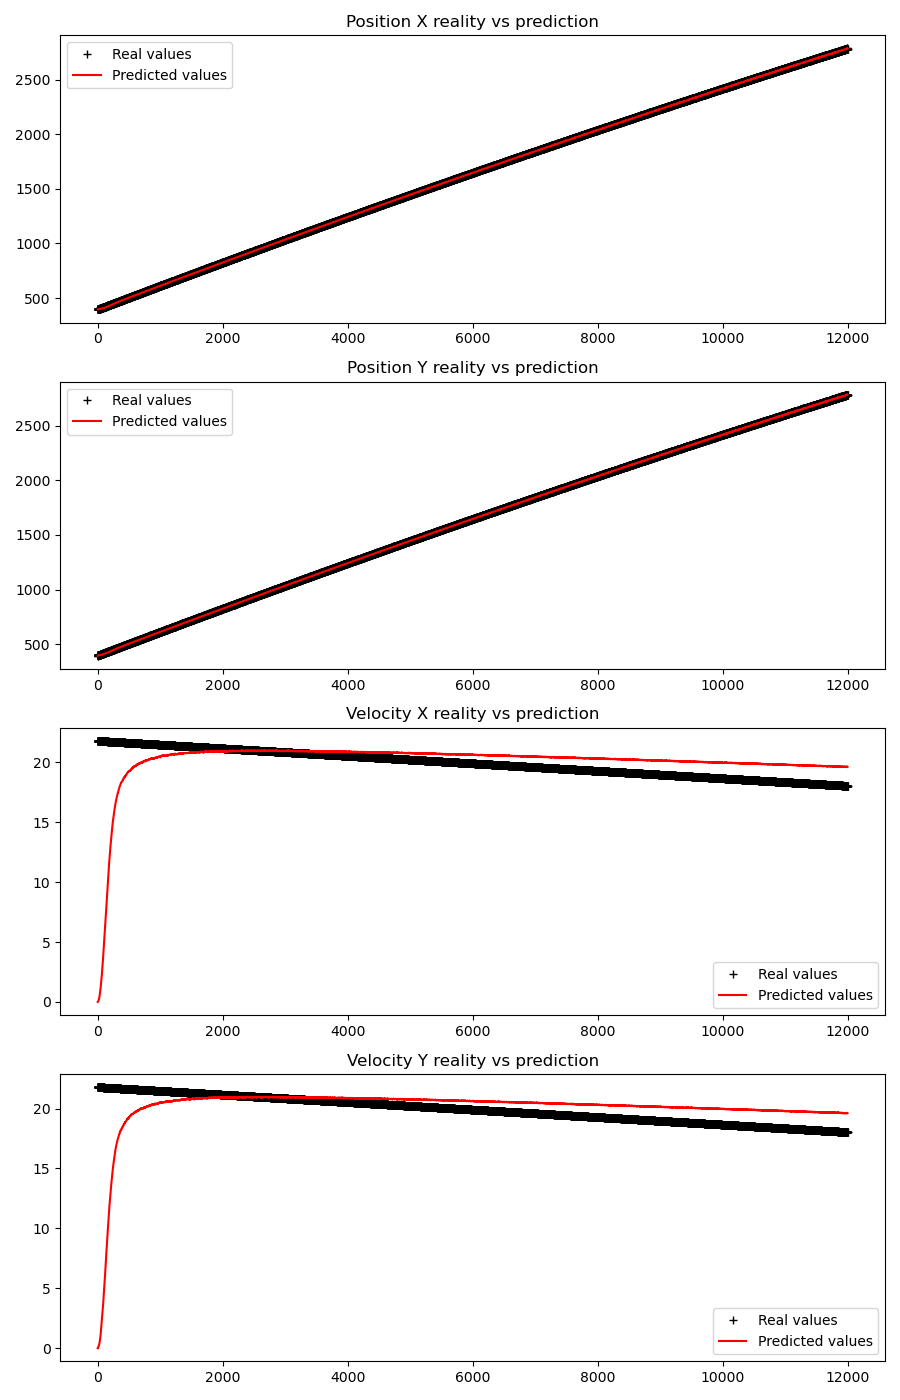

In [618]:
fig, ax = plt.subplots(4,1,figsize = (9,14))

ax[0].plot(measurement_history[:,0], "+k", label = "Real values")
ax[0].plot(states[:,0], "-r", label = "Predicted values")
ax[0].legend()
ax[0].set_title("Position X reality vs prediction")

ax[1].plot(measurement_history[:,1], "+k", label = "Real values")
ax[1].plot(states[:,1], "-r", label = "Predicted values")
ax[1].legend()
ax[1].set_title("Position Y reality vs prediction")

ax[2].plot(vehicle_velocity_history[:,0], "+k", label = "Real values")
ax[2].plot(states[:,2], "-r", label = "Predicted values")
ax[2].legend()
ax[2].set_title("Velocity X reality vs prediction")

ax[3].plot(vehicle_velocity_history[:,1], "+k", label = "Real values")
ax[3].plot(states[:,3], "-r", label = "Predicted values")
ax[3].legend()
ax[3].set_title("Velocity Y reality vs prediction")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


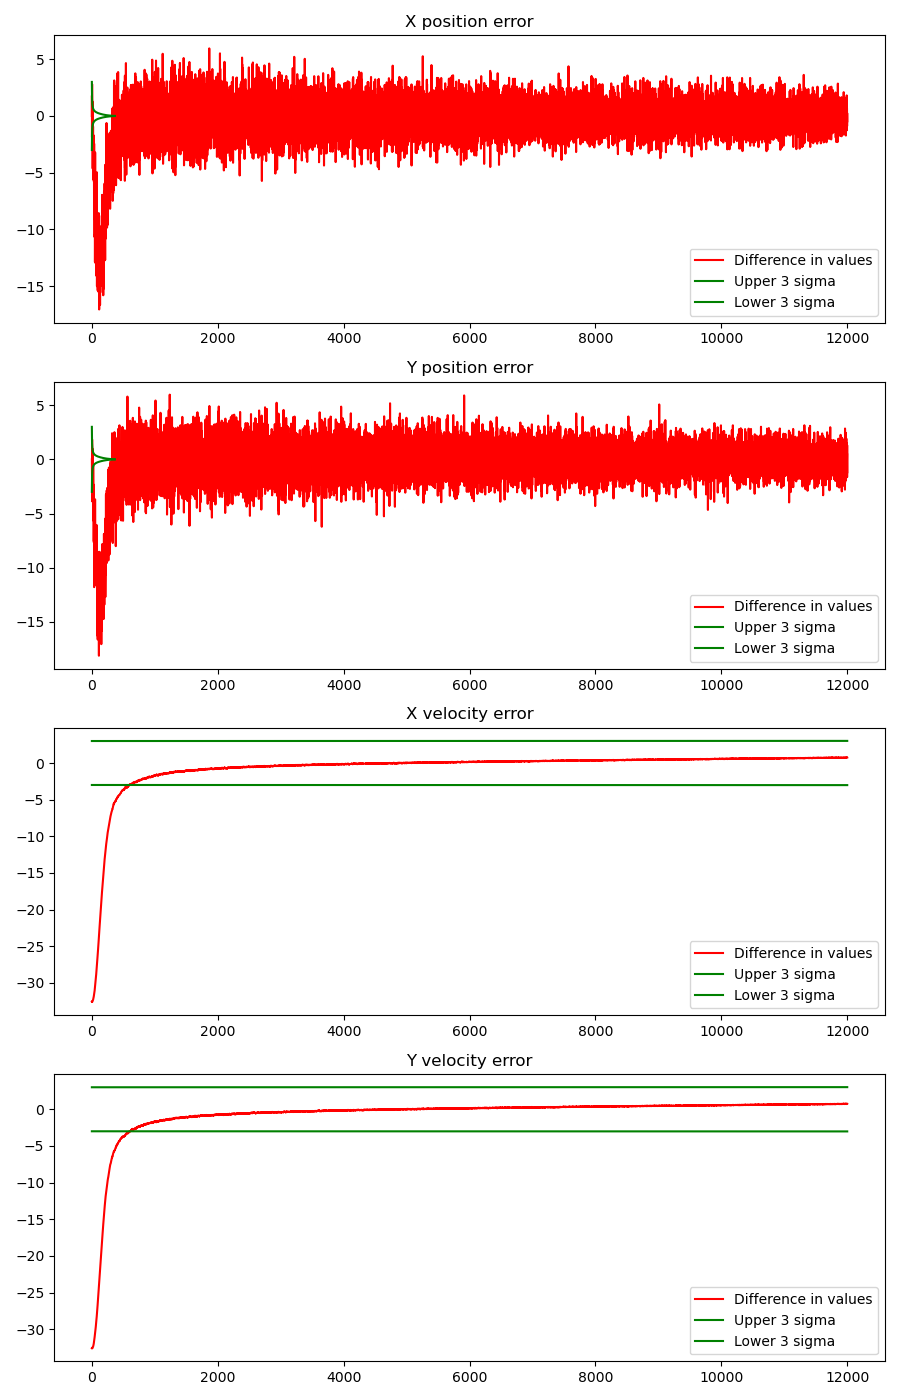

C:\Users\fberanek\AppData\Local\Temp/ipykernel_29836/3885692106.py:4: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(3*np.sqrt(covariances[:,0,0]), "-g", label = "Upper 3 sigma")
C:\Users\fberanek\AppData\Local\Temp/ipykernel_29836/3885692106.py:5: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(-3*np.sqrt(covariances[:,0,0]), "-g", label = "Lower 3 sigma")
C:\Users\fberanek\AppData\Local\Temp/ipykernel_29836/3885692106.py:10: RuntimeWarning: invalid value encountered in sqrt
  ax[1].plot(3*np.sqrt(covariances[:,1,1]), "-g", label = "Upper 3 sigma")
C:\Users\fberanek\AppData\Local\Temp/ipykernel_29836/3885692106.py:11: RuntimeWarning: invalid value encountered in sqrt
  ax[1].plot(-3*np.sqrt(covariances[:,1,1]), "-g", label = "Lower 3 sigma")


In [597]:
fig, ax = plt.subplots(4,1,figsize = (9,14))

ax[0].plot(states[:,0]-measurement_history[:,0], "-r", label = "Difference in values")
ax[0].plot(3*np.sqrt(covariances[:,0,0]), "-g", label = "Upper 3 sigma")
ax[0].plot(-3*np.sqrt(covariances[:,0,0]), "-g", label = "Lower 3 sigma")
ax[0].legend()
ax[0].set_title("X position error")

ax[1].plot(states[:,1]-measurement_history[:,1], "-r", label = "Difference in values")
ax[1].plot(3*np.sqrt(covariances[:,1,1]), "-g", label = "Upper 3 sigma")
ax[1].plot(-3*np.sqrt(covariances[:,1,1]), "-g", label = "Lower 3 sigma")
ax[1].legend()
ax[1].set_title("Y position error")


ax[2].plot(states[:,2]-vehicle_velocity_history[:,0], "-r", label = "Difference in values")
ax[2].plot(3*np.sqrt(covariances[:,2,2]), "-g", label = "Upper 3 sigma")
ax[2].plot(-3*np.sqrt(covariances[:,2,2]), "-g", label = "Lower 3 sigma")
ax[2].legend()
ax[2].set_title("X velocity error")

ax[3].plot(states[:,3]-vehicle_velocity_history[:,1], "-r", label = "Difference in values")
ax[3].plot(3*np.sqrt(covariances[:,3,3]), "-g", label = "Upper 3 sigma")
ax[3].plot(-3*np.sqrt(covariances[:,3,3]), "-g", label = "Lower 3 sigma")
ax[3].legend()
ax[3].set_title("Y velocity error")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


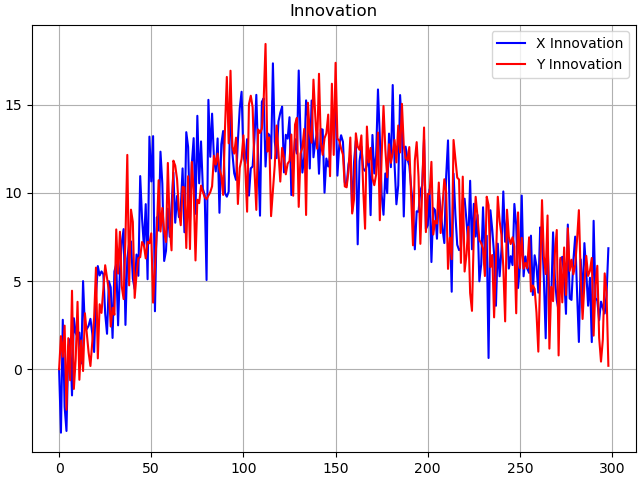

In [602]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True)
fig_ax = fig_of_plot.add_subplot(111,title='Innovation')#, aspect='equal', autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax.grid(True)

x_innovation_plot, = fig_ax.plot([],'-b', label = "X Innovation")
y_innovation_plot, = fig_ax.plot([], '-r', label = "Y Innovation")

def update_plot(i):
    x_innovation_plot.set_data(np.arange(0,len(innovation[:i,0]), 1), innovation[:i,0])
    y_innovation_plot.set_data(np.arange(0,len(innovation[:i,0]), 1), innovation[:i,1])
    fig_ax.relim()
    fig_ax.autoscale_view()
    return x_innovation_plot,y_innovation_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=number_of_frames, interval=0.0001)

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


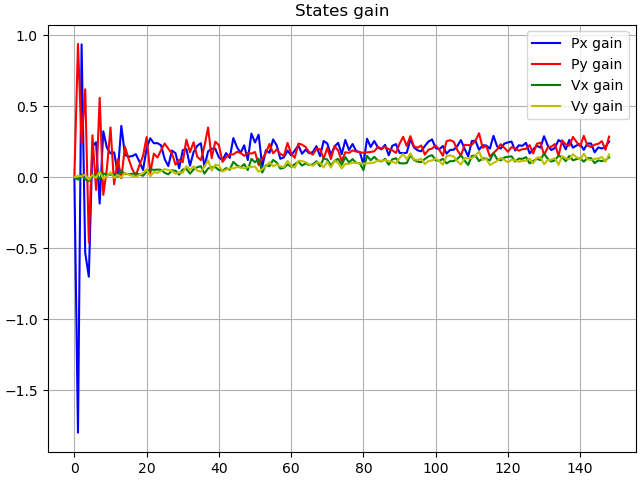

In [603]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True)
fig_ax = fig_of_plot.add_subplot(111,title='States gain')#, aspect='equal', autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax.grid(True)

px_gain, = fig_ax.plot([],'-b', label = "Px gain")
py_gain, = fig_ax.plot([], '-r', label = "Py gain")
vx_gain, = fig_ax.plot([],'-g', label = "Vx gain")
vy_gain, = fig_ax.plot([], '-y', label = "Vy gain")


def update_plot(i):
    output_data = []
    for row in range(i):
        gain = np.matmul(gain_values[row], innovation[row])
        print(gain)
        output_data.append(gain)
    output_data = np.array(output_data)
    if i > 0:
        px_gain.set_data(np.arange(0,len(output_data), 1), (output_data)[:,0])
        py_gain.set_data(np.arange(0,len(output_data), 1), (output_data)[:,1])
        vx_gain.set_data(np.arange(0,len(output_data), 1), (output_data)[:,2])
        vy_gain.set_data(np.arange(0,len(output_data), 1), (output_data)[:,3])
    fig_ax.relim()
    fig_ax.autoscale_view()
    return x_innovation_plot,y_innovation_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=number_of_frames, interval=0.0001)

plt.legend()
plt.show()


[0.16523936 0.25226518 0.09674871 0.14770289]
[0.19105568 0.26013338 0.11195508 0.15243333]
[0.19269046 0.24899476 0.11299145 0.14600764]
[0.21946034 0.18938734 0.12876368 0.11111899]
[0.26050336 0.151276   0.15291647 0.08879959]
[0.19991307 0.22751787 0.11739197 0.13360193]
[0.14568416 0.22420817 0.08556962 0.13169179]
[0.25365008 0.22813075 0.14900716 0.13401579]
[0.25700201 0.25567744 0.15098346 0.1502053 ]
[0.19229188 0.30860597 0.11296173 0.18129036]
[0.22390166 0.20653454 0.13151129 0.12131051]
[0.22253522 0.21991707 0.13067684 0.12913941]
[0.20015769 0.14531433 0.11749678 0.08530257]
[0.29053864 0.16953255 0.17047944 0.09947666]
[0.21641603 0.19389038 0.126921   0.11371043]
[0.2007459  0.23172565 0.11766005 0.13581773]
[0.23564842 0.20649174 0.13802203 0.12094462]
[0.2441777  0.17867902 0.14290765 0.10457384]
[0.25020504 0.21094749 0.14631068 0.12335431]
[0.1877542  0.20193324 0.10968968 0.11797335]
[0.22386648 0.18613166 0.13065553 0.1086323 ]
[0.22039818 0.19654827 0.12849214

<IPython.core.display.Javascript object>


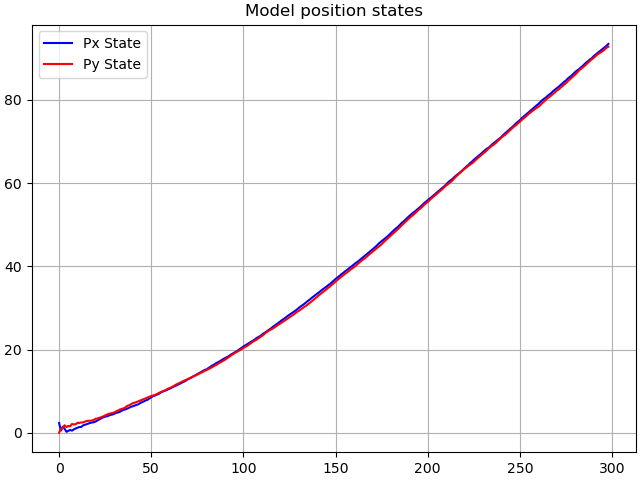

In [604]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True)
fig_ax = fig_of_plot.add_subplot(111,title='Model position states')#, aspect='equal', autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax.grid(True)

x_innovation_plot, = fig_ax.plot([],'-b', label = "Px State")
y_innovation_plot, = fig_ax.plot([], '-r', label = "Py State")

def update_plot(i):
    x_innovation_plot.set_data(np.arange(0,i, 1), np.array(states)[:i,0])
    y_innovation_plot.set_data(np.arange(0,i, 1), np.array(states)[:i,1])
    fig_ax.relim()
    fig_ax.autoscale_view()
    return x_innovation_plot,y_innovation_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=number_of_frames, interval=0.0001)

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


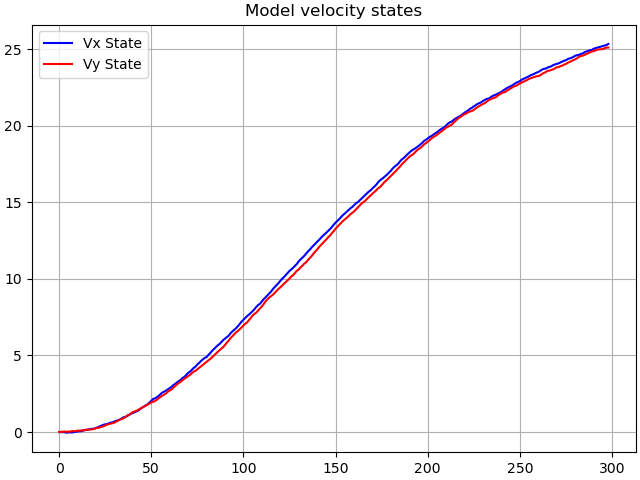

In [605]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize = (8,6))
# Plot Animation
fig_of_plot = plt.figure(constrained_layout=True)
fig_ax = fig_of_plot.add_subplot(111,title='Model velocity states')#, aspect='equal', autoscale_on=True, xlim=(0, 1000), ylim=(0, 1000))
fig_ax.grid(True)

x_innovation_plot, = fig_ax.plot([],'-b', label = "Vx State")
y_innovation_plot, = fig_ax.plot([], '-r', label = "Vy State")

def update_plot(i):
    x_innovation_plot.set_data(np.arange(0,i, 1), np.array(states)[:i,2])
    y_innovation_plot.set_data(np.arange(0,i, 1), np.array(states)[:i,3])
    fig_ax.relim()
    fig_ax.autoscale_view()
    return x_innovation_plot,y_innovation_plot

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=number_of_frames, interval=0.0001)

plt.legend()
plt.show()